# QuickStart

In this Notebook we run Archai's [Quickstart](https://microsoft.github.io/archai/getting_started/quick_start.html) example on Azure Machine Learning.

## Prerequisites

- Python 3.7 or later
- An Azure subscription
- An Azure Resource Group
- An Azure Machine Learning [Workspace](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources#create-the-workspace)

This notebook also assumes you have a python environment setup using `pip install -e .[aml]` in your Archai repository root

In [ ]:
from pathlib import Path

from IPython.display import display, Image
from IPython.core.display import HTML

from azure.ai.ml import Output, command

import archai.common.azureml_helper as aml_helper
import archai.common.notebook_helper as nb_helper

### Get a handle to the workspace

We load the workspace from a workspace [configuration file](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-configure-environment#local-and-dsvm-only-create-a-workspace-configuration-file).

In [ ]:
ml_client = aml_helper.get_aml_client_from_file("../.azureml/config.json")
print(f'Using workspace: {ml_client.workspace_name} in resource group: {ml_client.resource_group_name}')

### Create a compute cluster

We provision a Linux [compute cluster](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-attach-compute-cluster?tabs=python) for this Notebook. See the [full list](https://azure.microsoft.com/en-ca/pricing/details/machine-learning/) on VM sizes and prices.

In [3]:
cpu_compute_name = "nas-cpu-cluster-D14-v2"
compute_cluster = aml_helper.create_compute_cluster(ml_client, cpu_compute_name)

You already have a cluster named nas-cpu-cluster-D14-v2, we'll reuse it as is.


### Create an environment based on a YAML file

Azure Machine Learning maintains a set of CPU and GPU Ubuntu Linux-based base images with common system dependencies. For the set of base images and their corresponding Dockerfiles, see the [AzureML Containers](https://github.com/Azure/AzureML-Containers) repo.

In [4]:
archai_job_env = aml_helper.create_environment_from_file(ml_client,
                                                         image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest",
                                                         conda_file="conda.yaml",
                                                         version="0.0.1")

Environment with name aml-archai is registered to workspace, the environment version is 0.0.1


### Create job

In [5]:
job = command(experiment_name="archai_quickstart",
              display_name="Archai's QuickStart",
              compute=cpu_compute_name,
              environment=f"{archai_job_env.name}:{archai_job_env.version}",
              code="main.py",
              outputs=dict(
                  output_path=Output(type="uri_folder", mode="rw_mount")
              ),
              command="python main.py --output_dir ${{outputs.output_path}}"
              )

### Run job

In [6]:
quickstart_job = ml_client.create_or_update(job)

Uploading main.py (< 1 MB): 100%|##########| 1.74k/1.74k [00:00<00:00, 6.91kB/s]




Open the job overview on Azure ML Studio in your web browser (this works when you are running this notebook in VS code).

In [7]:
import webbrowser
webbrowser.open(quickstart_job.services["Studio"].endpoint)

job_name = quickstart_job.name
print(f'Started job: {job_name}')

Started job: busy_shampoo_cqjgwy28gc


### Download job's output

In [ ]:
output_name = "output_path"
download_path = "output"

aml_helper.download_job_output(ml_client, job_name=quickstart_job.name, output_name=output_name, download_path=download_path)

downloaded_folder = Path(download_path) / "named-outputs" / output_name

### Show Pareto Frontiers

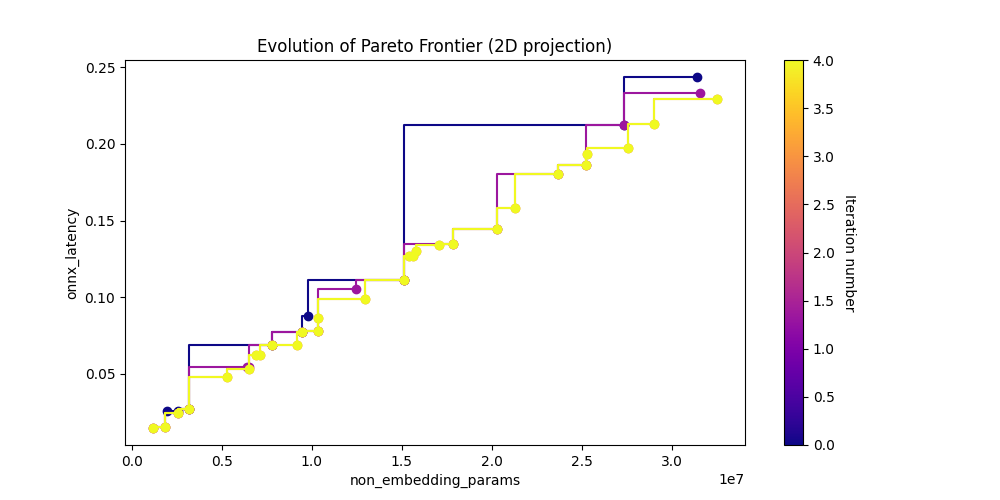

In [9]:
param_vs_latency_img = Image(filename=downloaded_folder / "pareto_non_embedding_params_vs_onnx_latency.png")
display(param_vs_latency_img)

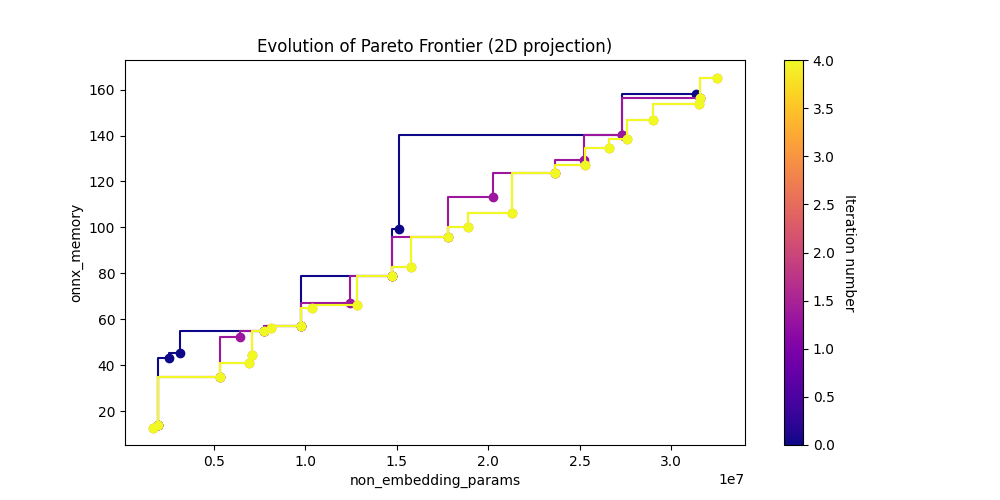

In [10]:
param_vs_memory_img = Image(filename=downloaded_folder / "pareto_non_embedding_params_vs_onnx_memory.png")
display(param_vs_memory_img)

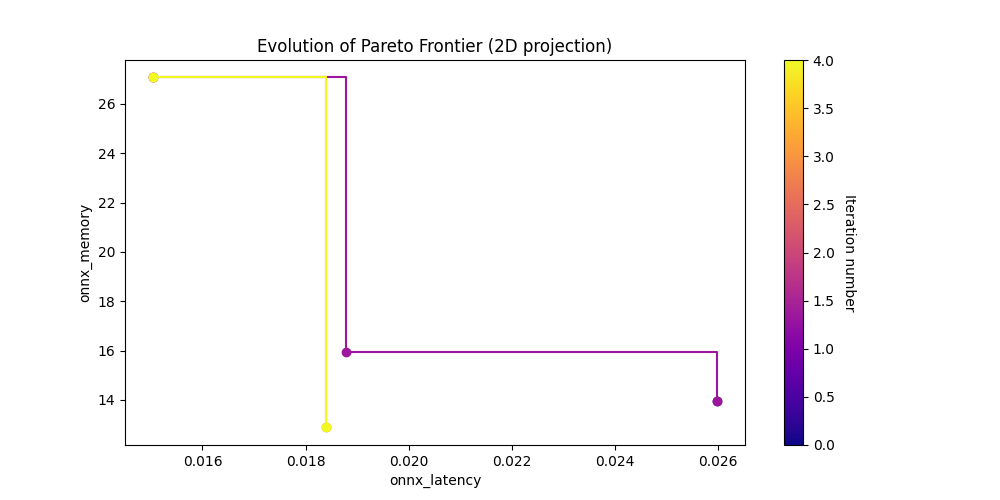

In [11]:
latency_vs_memory_img = Image(filename=downloaded_folder / "pareto_onnx_latency_vs_onnx_memory.png")
display(latency_vs_memory_img)

### Show search state of the last iteration

In [12]:
df = nb_helper.get_search_csv(downloaded_folder)
df = df.drop('parent', axis=1)
df = df.drop('parents', axis=1)

csv_as_html = nb_helper.get_csv_as_stylized_html(df)
display(HTML(csv_as_html))

,archid,non_embedding_params,onnx_latency,onnx_memory,iteration_num,search_walltime_hours,is_pareto
0,gpt2_9d012fda4e2572401bcaf2a40ae64609486ad1b1,15144192.000000,0.111368,99.110383,0,0.043973,True
1,gpt2_2ce523ffef6587e0a9790c173a89d6fd25f1b9b6,7769472.000000,0.068997,54.867023,0,0.043973,True
2,gpt2_3a0de44149328513a2d87829af64a3caf0cda00a,14724096.000000,0.127590,78.704400,0,0.043973,False
3,gpt2_1f64435b4c2b16e543696622d0eab28ca7a91654,31372992.000000,0.243274,158.277772,0,0.043973,False
4,gpt2_38c27b9259337e9d1e19706d5a2a18d3207a74f4,27327616.000000,0.212588,140.166085,0,0.043973,False
5,gpt2_e24cd64a53d6a9be4a5cf2116daee38e0763947c,9791616.000000,0.087752,57.236445,0,0.043973,True
6,gpt2_f99008efea75c6af754c633dbf1ce910c3829261,2564480.000000,0.026018,43.084689,0,0.043973,False
7,gpt2_ad522de7b54d7ad73231ccab52e7f8b17c444dd8,3154688.000000,0.027303,45.336156,0,0.043973,True
8,gpt2_3b76e4046ead432cab16d17d0a3d500efc0249c5,1963840.000000,0.025981,13.966668,0,0.043973,True
9,gpt2_56b3029ce65d7c75585e97c67a3162b6b34fd453,9462656.000000,0.077058,61.318761,0,0.043973,True
